# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:\n', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like:
 [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [4]:
# for i in range(5):                                         # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [5]:
# env.close()

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch

from maddpg_agent import Agent
from collections import deque
from unityagents import UnityEnvironment

%matplotlib inline

In [7]:
TARGET_SCORE = 0.51
EPISODES = 100
PRINT_EVERY = 10
ADD_NOISE = True
RANDOM_SEED = 0

In [8]:
# MADDPG function

def maddpg(n_episodes=2000, max_t=1000, print_every = 50):
    """Multi-Agent Deep Deterministic Policy Gradient (MADDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        print_every (int)     : print every x iterations
    """
    scores_queue = deque(maxlen=EPISODES)
    scores_list = []
    average_score = []
    
    best_score = -np.inf
    best_episode = 0

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]         # reset environment
        states = np.reshape(env_info.vector_observations, (1,2 * state_size)) # get states 
        agent_0.reset()
        agent_1.reset()
        scores = np.zeros(num_agents)
        
        while True:
            actions = get_actions(states)           # choose the action
            env_info = env.step(actions)[brain_name]           # send actions to the environment
            rewards = env_info.rewards                         # select rewards
            done = env_info.local_done                         # episode state situation

            next_states = np.reshape(env_info.vector_observations, (1, 2 * state_size)) # obtain next states
            
            agent_0.step(states, actions, rewards[0], next_states, done, 0) # learn agent 1 
            agent_1.step(states, actions, rewards[1], next_states, done, 1) # Learn agent 2
            scores += np.max(rewards)                          # add the best score
            states = next_states                               # roll over states to next time step
            
            if np.any(done):                                   # exit loop once episode is complete.
                break

        episode_best_score = np.max(scores)
        scores_queue.append(episode_best_score)
        scores_list.append(episode_best_score) # list of best episodic scores
        average_score.append(np.mean(scores_queue))

        # save optimum scores                        
        if episode_best_score > best_score:
            best_episode = i_episode
            best_score = episode_best_score
        
        # print results
        if i_episode % print_every == 0:
            print('Episode {:0>4d}\t Average Score: {:.3f}'.format(i_episode, average_score[-1]))

        # determine if environment is solved and keep best performing models
        if average_score[-1] >= TARGET_SCORE:
            print('-- Environment solved in {:d} episodes! \
                \n-- Average Score: {:.3f} over past {:d} episodes'.format(
                    i_episode-EPISODES, average_score[-1], EPISODES))
            # save weights
            torch.save(agent_0.actor_local.state_dict(), '0_checkpoint_actor.pth')
            torch.save(agent_0.critic_local.state_dict(), '0_checkpoint_critic.pth')
            torch.save(agent_1.actor_local.state_dict(), '1_checkpoint_actor.pth')
            torch.save(agent_1.critic_local.state_dict(), '1_checkpoint_critic.pth')
            break
           
            
    return scores_list

In [9]:
def get_actions(states):
    '''gets actions for each agent and a single array with both actions'''
    action_0 = agent_0.act(states)    
    action_1 = agent_1.act(states)    
    x = np.concatenate((action_0, action_1), axis=0).flatten()
    return x

In [10]:
# initialize agents
agent_0 = Agent(state_size, action_size, num_agents=1, random_seed=RANDOM_SEED)
agent_1 = Agent(state_size, action_size, num_agents=1, random_seed=RANDOM_SEED)

In [11]:
scores = maddpg()

Episode 0050	 Average Score: 0.014
Episode 0100	 Average Score: 0.014
Episode 0150	 Average Score: 0.023
Episode 0200	 Average Score: 0.039
Episode 0250	 Average Score: 0.063
Episode 0300	 Average Score: 0.085
Episode 0350	 Average Score: 0.106
Episode 0400	 Average Score: 0.138
Episode 0450	 Average Score: 0.147
Episode 0500	 Average Score: 0.182
Episode 0550	 Average Score: 0.284
Episode 0600	 Average Score: 0.333
-- Environment solved in 536 episodes!                 
-- Average Score: 0.525 over past 100 episodes


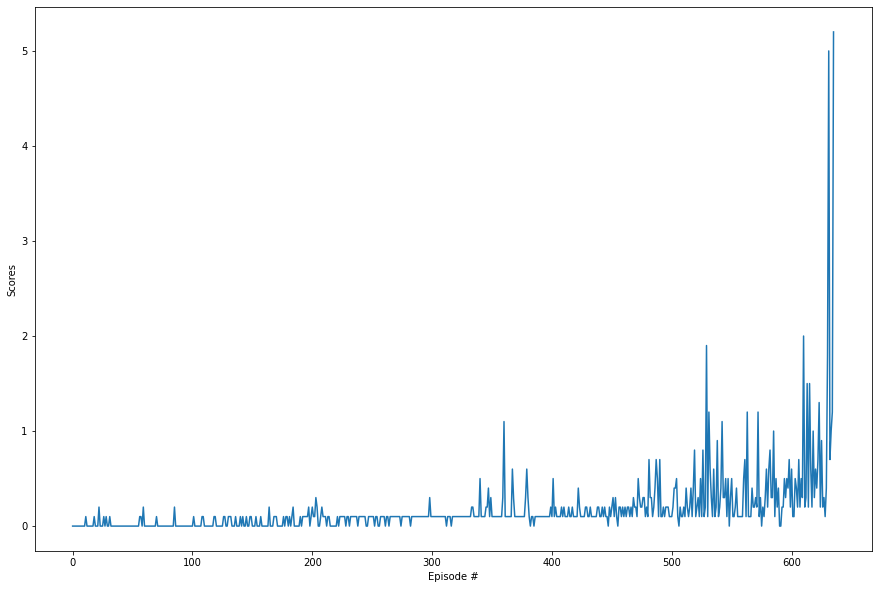

In [18]:
plt.rcParams["figure.figsize"] = (15,10)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='MADDPG')
plt.ylabel('Scores')
plt.xlabel('Episode #')
plt.show()

In [13]:
# env.close()